In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
!conda install -c conda-forge wikipedia=1.4.0 --yes
import wikipedia as wp


In [5]:
#Get the html source
html = wp.page("List of areas of London").html().encode("UTF-8")
df = pd.read_html(html)[1]
df.head()

Location                     London borough       Post town  \
0   Abbey Wood              Bexley, Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode district Dial code OS grid ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

In [6]:
df.columns

Index(['Location', 'London borough', 'Post town', 'Postcode district',
       'Dial code', 'OS grid ref'],
      dtype='object')

In [7]:
df.columns = ['Location','London_borough','Post town','Postcode district','Dial Code','OS grid ref']
df['London_borough'] =  df['London_borough'].apply(lambda x: x.replace('[','').replace(']','')) 
df['London_borough'] =  df['London_borough'].str.replace('\d+', '')
df['London_borough'] =  df['London_borough'].str.split(',').str[0]
df=df.drop(['Dial Code','OS grid ref','Post town'],axis=1)
df.head()

Location London_borough Postcode district
0   Abbey Wood         Bexley               SE2
1        Acton         Ealing            W3, W4
2    Addington        Croydon               CR0
3   Addiscombe        Croydon               CR0
4  Albany Park         Bexley         DA5, DA14

In [8]:
# Using Beautiful Soup to parse the website's html
from bs4 import BeautifulSoup

data = requests.get('https://propertydata.co.uk/cities/london').text
soup = BeautifulSoup(data, 'html.parser')

In [9]:
neighborhoodList = []
for index, table in enumerate(soup.find_all("table")):
    for row in table.find_all("tr"):
        cells = row.find_all("td")
        name = row.find_all("td")

        if len(cells) > 0:
            neighborhoodName = name[0].text.lstrip("<td>").strip()
            avgPrice = cells[2].text.lstrip("£").strip()
            avgPrice2 = avgPrice.replace(",", "")
            
                
            neighborhoodList.append((
                neighborhoodName,
                avgPrice2
            ))

In [10]:
# Put the scrapped data into a dataframe
df2 = pd.DataFrame(neighborhoodList)
df2.columns = ['neighborhoodName', 'AvgPrice']

In [11]:
df2 = pd.DataFrame(neighborhoodList)
df2.columns = ['Postcode district', 'AvgPrice']
df2 = df2.iloc[1:]
df2['AvgPrice']=df2['AvgPrice'].astype(str).astype(float)
print(df2.shape)
df2.head()

(212, 2)


Postcode district  AvgPrice
1               BR1  434986.0
2               BR2  510478.0
3               BR3  455860.0
4               BR5  450548.0
5               BR6  544548.0

In [12]:
data=pd.merge(df, df2, how='inner', left_on='Postcode district', right_on='Postcode district')

In [14]:
!conda install -c conda-forge geocoder=1.38.1 --yes


import geocoder as geocoder

def getLatLong(row):
    #print('post :{}'.format(row[:]))
    #print('neigh :{}'.format(row[1]))
    # initialize your variable to None
    lat_lng_coords = None
    search_query = '{}, London,UK'.format(row)
    # loop until you get the coordinates
    try:
        while(lat_lng_coords is None):
            #g = geocoder.here(search_query,app_id=app_id,app_code=app_code)
            g = geocoder.arcgis(search_query)
            lat_lng_coords = g.latlng
            #print('FIRST')
    except IndexError:
        latitude = 0.0
        longitude = 0.0
        print('BACKUP')
        return [latitude,longitude]

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print(latitude, longitude)
    return [latitude, longitude]

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder=1.38.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          59 KB

The following NEW packages will be INSTALLED:

    geocoder: 1.38.1-py_1 conda-forge
    ratelim:  0.1.6-py_2  conda-forge


ratelim-0.1.6        | 6 KB      | ##################################### | 100% 
geocoder-1.38.1      | 53 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [15]:
coords_list = data['Postcode district'].apply(getLatLong).tolist()


51.492450000000076 0.12127000000003818
51.492450000000076 0.12127000000003818
51.492450000000076 0.12127000000003818
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.38475500000004 -0.05149847299992416
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.51651000000004 -0.11967999999995982
51.51651000000004 -0.11967999999995982
51.51651000000004 -0.11967999999995982
51.51651000000004 -0.11967999999995982
51.50642000000005 -0.1272099999999341
51.41009000000008 -0.05682999999993399
51.41009000000008 -0.05682999999993399
51.27179309706539 0.07472437841542252
51.27179309706539 0.07472437841542252
51.56393000000003 -0.12944999999996298
51.56393000000003 -0.1294499999

51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.58170000000007 -0.12092999999993026
51.58170000000007 -0.12092999999993026
51.58170000000007 -0.12092999999993026
51.34502864516327 0.13272826339762203
51.54505000000006 -0.05531999999993786
51.54505000000006 -0.05531999999993786
51.48114000000004 -0.02466999999995778
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.45066000000003 -0.18996999999995978
51.45066000000003 -0.18996999999995978
51.44844804245899 -0.44849085603639316
51.44844804245899 -0.44849085603639316
51.45256000000006 -0.0707599999999502
51.589270000000056 -0.16394999999994297
51.589270000000056 -0.16394999999994297
51.53292000000005 0.05461000000002514
51.46482000000003 -0.26590999999996257
51.46482000000003 -0.26590999999996257
51.45907500000004 0.09912069600005

51.3754260323315 -0.1523582305531097
51.487640000000056 -0.09541999999993322
51.48563000000007 -0.1814399999999523
51.514530000000036 -0.31950999999997975
51.49568000000005 -0.2099299999999289
51.43407000000008 -0.10374999999993406
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341
51.50642000000005 -0.1272099999999341


In [16]:
data[['Latitude','Longitude']]=pd.DataFrame(coords_list,columns=['Latitude', 'Longitude'])
data.head()

Location London_borough Postcode district  AvgPrice   Latitude  Longitude
0  Abbey Wood         Bexley               SE2  368814.0  51.492450   0.121270
1   Crossness         Bexley               SE2  368814.0  51.492450   0.121270
2  West Heath         Bexley               SE2  368814.0  51.492450   0.121270
3   Addington        Croydon               CR0  347577.0  51.384755  -0.051498
4  Addiscombe        Croydon               CR0  347577.0  51.384755  -0.051498

In [17]:
address = 'London'

geolocator = Nominatim(user_agent="ldn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [18]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['London_borough'], data['Location']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [19]:
CLIENT_ID = "4GLQ5PSLFUEAWQJDSB4D4K2MPHTWFNOVBU4WLU5HN0UCFCQO"
CLIENT_SECRET = "CRKQSJS52NDVAP44QVVAL4MQKNCMYOHXLZAORG2Y5FSTSD4M"
VERSION = "20200804"

In [20]:
def getBuiltUrl(neigh_lat,neigh_long,radius=1400):
    # type your answer here
    LIMIT=100
    #radius=1000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_lat, 
    neigh_long, 
    radius, 
    LIMIT)
    return url

In [21]:
neigh_name, neigh_borough, neigh_post, neigh_price, neigh_lat, neigh_long = data.iloc[0]
print('Latitude and longitude values of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_lat, 
                                                               neigh_long))
results = requests.get(getBuiltUrl(neigh_lat,neigh_long)).json()
results

Latitude and longitude values of Abbey Wood are 51.492450000000076, 0.12127000000003818.


{'meta': {'code': 200, 'requestId': '5f2a9f228f44ac7ed521aeff'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bexley',
  'headerFullLocation': 'Bexley, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 10,
  'suggestedBounds': {'ne': {'lat': 51.50505001260009,
    'lng': 0.14146937077953206},
   'sw': {'lat': 51.479849987400065, 'lng': 0.1010706292205443}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c51917b9d642d7ffacdc3dd',
       'name': 'Lesnes Abbey',
       'location': {'address': 'Abbey Rd',
        'lat': 51.48952562827752,
        'lng': 0.1258393207225854,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.48952562827752,
 

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name     categories        lat       lng
0                      Lesnes Abbey  Historic Site  51.489526  0.125839
1                              Lidl    Supermarket  51.496152  0.118417
2                       Sainsbury's    Supermarket  51.492826  0.120524
3                        Co-op Food  Grocery Store  51.487650  0.113490
4  Abbey Wood Railway Station (ABW)  Train Station  51.490825  0.123432

In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


10 venues were returned by Foursquare.


In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        LIMIT=100
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
london_venues = getNearbyVenues(names=data['Location'], 
                                   latitudes=data['Latitude'], 
                                   longitudes=data['Longitude'], 
                                   radius=500)

Abbey Wood
Crossness
West Heath
Addington
Addiscombe
Coombe
Croydon
Forestdale
New Addington
Shirley
Waddon
Woodside
Aldborough Hatch
Gants Hill
Newbury Park
Aldwych
Charing Cross
Covent Garden
St Giles
Alperton
Anerley
Penge
Aperfield
Biggin Hill
Archway
Upper Holloway
Ardleigh Green
Emerson Park
Balham
Bankside
Bermondsey
Lambeth
Barbican
Clerkenwell
Farringdon
Finsbury
St Luke's
Barking
Creekmouth
Barkingside
Barnehurst
Barnes
Castelnau
Barnes Cray
Crayford
Barnet (also Chipping Barnet, High Barnet)
Monken Hadley
Temple Fortune
Barnsbury
Canonbury
De Beauvoir Town
Hoxton
Islington
Pentonville
Shoreditch
Battersea
Bayswater
Paddington
Becontree
Castle Green
Becontree Heath
Bedford Park
Chiswick
Grove Park
Gunnersbury
Belgravia
Knightsbridge
Millbank
Pimlico
St James's
Westminster
Bellingham
Catford
Southend
Belmont
Belsize Park
Frognal
Hampstead
Swiss Cottage
Belvedere
Lessness Heath
Berrylands
Bethnal Green
Cambridge Heath
Haggerston
Bickley
Bromley Common
Eden Park
Elmers End
Black

In [28]:
print(london_venues.shape)
london_venues.head()

(16288, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0   Abbey Wood               51.49245                 0.12127   
1   Abbey Wood               51.49245                 0.12127   
2   Abbey Wood               51.49245                 0.12127   
3   Abbey Wood               51.49245                 0.12127   
4   Abbey Wood               51.49245                 0.12127   

                              Venue  Venue Latitude  Venue Longitude  \
0                       Sainsbury's       51.492826         0.120524   
1                      Lesnes Abbey       51.489526         0.125839   
2                              Lidl       51.496152         0.118417   
3  Abbey Wood Railway Station (ABW)       51.490825         0.123432   
4                        Costcutter       51.491287         0.120938   

      Venue Category  
0        Supermarket  
1      Historic Site  
2        Supermarket  
3      Train Station  
4  Convenience Store

In [29]:
london_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                            
Abbey Wood                                                          6   
Addington                                                           4   
Addiscombe                                                          4   
Aldborough Hatch                                                   81   
Aldwych                                                            91   
Alperton                                                           81   
Anerley                                                             6   
Aperfield                                                           3   
Archway                                                            30   
Ardleigh Green                                                      4   
Balham                                                             36   
Bankside                                                           52   
Barbican                                                           75   
Barking                                                             6   
Barkingside                                                        81   
Barnehurst                                                          5   
Barnes                                                             24   
Barnes Cray                                                         7   
Barnet (also Chipping Barnet, High Barnet)                          4   
Barnsbury                                                          49   
Battersea                                                          26   
Bayswater                                                         100   
Becontree                                                          81   
Becontree Heath                                                    81   
Bedford Park                                                       38   
Belgravia                                                          93   
Bellingham                                                          5   
Belmont                                                            81   
Belsize Park                                                       52   
Belvedere                                                           4   
Bermondsey                                                         52   
Berrylands                                                         81   
Bethnal Green                                                      36   
Bickley                                                             4   
Biggin Hill                                                         3   
Blackfen                                                            5   
Blackfriars                                                       100   
Blackheath                                                          2   
Blackwall                                                           9   
Bloomsbury                                                         48   
Botany Bay                                                          3   
Bow                                                                10   
Bowes Park                                                          5   
Brent Park                                                          8   
Brentford                                                          13   
Brimsdown                                                           5   
Brockley                                                           35   
Bromley (also Bromley-by-Bow)                                      10   
Bromley Common                                                      4   
Brompton                                                           95   
Brondesbury                                                        30   
Brunswick Park                                                      7   
Burnt Oak                                                           4   
Burroughs, The                   

In [30]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))


There are 306 uniques categories.


In [31]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0   Abbey Wood                  0               0                   0   
1   Abbey Wood                  0               0                   0   
2   Abbey Wood                  0               0                   0   
3   Abbey Wood                  0               0                   0   
4   Abbey Wood                  0               0                   0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    0             0       0                 0   
1                    0             0       0                 0   
2                    0             0       0                 0   
3                    0             0       0                 0   
4                    0             0       0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  Auto Garage  \
0                 0                   0                      0            0   
1                 0                   0                      0            0   
2                 0                   0                      0            0   
3                 0                   0                      0            0   
4                 0                   0                      0            0   

   Auto Workshop  BBQ Joint  Bagel Shop  Bakery  Bar  Beach  Bed & Breakfast  \
0              0          0           0       0    0      0                0   
1              0          0           0       0    0      0                0   
2              0          0           0       0    0      0                0   
3              0          0           0       0    0      0                0   
4              0          0           0       0    0      0                0   

   Beer Bar  Beer Garden  Beer Store  Betting Shop  Bike Shop  Bistro  \
0         0            0           0             0          0       0   
1         0            0           0             0          0       0   
2         0            0           0             0          0       0   
3         0            0           0             0          0       0   
4         0            0           0             0          0       0   

   Boarding House  Bookstore  Boutique  Boxing Gym  Brasserie  \
0               0          0         0           0          0   
1               0          0         0           0          0   
2               0          0         0           0          0   
3               0          0         0           0          0   
4               0          0         0           0          0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Building  Burger Joint  \
0                     0               0        0         0             0   
1                     0               0        0         0             0   
2                     0               0        0         0             0   
3                     0               0        0         0             0   
4                     0               0        0         0             0   

   Burrito Place  Bus Station  Bus Stop  Business Service  Butcher  Café  \
0              0            0         0                 0        0     0   
1              0            0         0                 0        0     0   
2              0            0         0                 0        0     0   
3              0            0         0                 0        0     0   
4              0            0         0                 0        0     0   

   Camera Store

In [32]:
london_onehot.shape


(16288, 307)

In [33]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped
a=london_grouped
a.head()

Neighborhood  Accessories Store  Adult Boutique  African Restaurant  \
0        Abbey Wood           0.000000             0.0                 0.0   
1         Addington           0.000000             0.0                 0.0   
2        Addiscombe           0.000000             0.0                 0.0   
3  Aldborough Hatch           0.000000             0.0                 0.0   
4           Aldwych           0.010989             0.0                 0.0   

   American Restaurant  Antique Shop    Arcade  Arepa Restaurant  \
0                  0.0      0.000000  0.000000               0.0   
1                  0.0      0.000000  0.000000               0.0   
2                  0.0      0.000000  0.000000               0.0   
3                  0.0      0.000000  0.000000               0.0   
4                  0.0      0.010989  0.010989               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                0.000000     0.000000    0.000000                  0.0   
1                0.000000     0.250000    0.000000                  0.0   
2                0.000000     0.250000    0.000000                  0.0   
3                0.000000     0.024691    0.024691                  0.0   
4                0.010989     0.000000    0.000000                  0.0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  Auto Garage  \
0               0.0                 0.0                    0.0          0.0   
1               0.0                 0.0                    0.0          0.0   
2               0.0                 0.0                    0.0          0.0   
3               0.0                 0.0                    0.0          0.0   
4               0.0                 0.0                    0.0          0.0   

   Auto Workshop  BBQ Joint  Bagel Shop    Bakery       Bar  Beach  \
0            0.0        0.0         0.0  0.000000  0.000000    0.0   
1            0.0        0.0         0.0  0.000000  0.000000    0.0   
2            0.0        0.0         0.0  0.000000  0.000000    0.0   
3            0.0        0.0         0.0  0.012346  0.012346    0.0   
4            0.0        0.0         0.0  0.021978  0.010989    0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Betting Shop  \
0              0.0  0.000000          0.0         0.0           0.0   
1              0.0  0.000000          0.0         0.0           0.0   
2              0.0  0.000000          0.0         0.0           0.0   
3              0.0  0.000000          0.0         0.0           0.0   
4              0.0  0.021978          0.0         0.0           0.0   

   Bike Shop  Bistro  Boarding House  Bookstore  Boutique  Boxing Gym  \
0        0.0     0.0             0.0   0.000000  0.000000         0.0   
1        0.0     0.0             0.0   0.000000  0.000000         0.0   
2        0.0     0.0             0.0   0.000000  0.000000         0.0   
3        0.0     0.0             0.0   0.012346  0.012346         0.0   
4        0.0     0.0             0.0   0.032967  0.000000         0.0   

   Brasserie  Brazilian Restaurant  Breakfast Spot  Brewery  Building  \
0   0.000000                   0.0             0.0      0.0       0.0   
1   0.000000                   0.0             0.0      0.0       0.0   
2   0.000000                   0.0             0.0      0.0       0.0   
3   0.000000                   0.0             0.0      0.0       0.0   
4   0.010989                   0.0             0.0      0.0       0.0   

   Burger Joint  Burrito Place  Bus Station  Bus Stop  Business Service  \
0      0.000000       0.000000          0.0       0.0               0.0   
1      0.000000       0.000000          0.0       0.0               0.0   
2      0.000000       0.000000          0.0       0.0               0.0   
3      0.024691       0.000000          0.0       0.0               0.0   
4      0.021978       0.010989          0.0       0.0               0.0   

   Butcher      Café  Came

In [34]:
num_top_venues = 5

for hood in a['Neighborhood']:
    print("----"+hood+"----")
    temp = a[a['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
               venue  freq
0        Supermarket  0.33
1  Convenience Store  0.17
2      Train Station  0.17
3      Historic Site  0.17
4           Platform  0.17


----Addington----
               venue  freq
0  Recreation Center  0.25
1  Fish & Chips Shop  0.25
2      Grocery Store  0.25
3        Art Gallery  0.25
4    Organic Grocery  0.00


----Addiscombe----
               venue  freq
0  Recreation Center  0.25
1  Fish & Chips Shop  0.25
2      Grocery Store  0.25
3        Art Gallery  0.25
4    Organic Grocery  0.00


----Aldborough Hatch----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04


----Aldwych----
            venue  freq
0             Pub  0.09
1  Sandwich Place  0.07
2            Café  0.05
3         Theater  0.04
4           Hotel  0.04


----Alperton----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  C

                venue  freq
0                Café   0.2
1                 Pub   0.2
2         Supermarket   0.2
3          Playground   0.2
4  Turkish Restaurant   0.2


----Brockley----
               venue  freq
0  Convenience Store  0.11
1               Café  0.09
2      Grocery Store  0.09
3          Gastropub  0.06
4        Pizza Place  0.06


----Bromley (also Bromley-by-Bow)----
                 venue  freq
0                  Pub   0.3
1  Rental Car Location   0.1
2   Light Rail Station   0.1
3             Bus Stop   0.1
4         Burger Joint   0.1


----Bromley Common----
                   venue  freq
0     Athletics & Sports  0.50
1          Train Station  0.25
2                   Park  0.25
3    Peruvian Restaurant  0.00
4  Performing Arts Venue  0.00


----Brompton----
                 venue  freq
0                Hotel  0.05
1                 Café  0.05
2  Japanese Restaurant  0.05
3   English Restaurant  0.04
4                  Pub  0.04


----Brondesbury----
           

          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04


----Crayford----
                      venue  freq
0                       Pub  0.29
1        Italian Restaurant  0.14
2      Medical Supply Store  0.14
3               Supermarket  0.14
4  Mediterranean Restaurant  0.14


----Creekmouth----
           venue  freq
0  Grocery Store  0.33
1           Park  0.17
2           Café  0.17
3    Supermarket  0.17
4            Spa  0.17


----Crews Hill----
                        venue  freq
0                        Lake  0.33
1                         Pub  0.33
2  Construction & Landscaping  0.33
3                Optical Shop  0.00
4       Performing Arts Venue  0.00


----Cricklewood----
                  venue  freq
0           Music Venue   0.2
1  Gym / Fitness Center   0.2
2           Supermarket   0.2
3            Hookah Bar   0.2
4        Clothing Store   0.2


----Crofton Park----
               venue  fr

               venue  freq
0  Recreation Center  0.25
1  Fish & Chips Shop  0.25
2      Grocery Store  0.25
3        Art Gallery  0.25
4    Organic Grocery  0.00


----Fortis Green----
           venue  freq
0           Café  0.13
1    Coffee Shop  0.09
2            Pub  0.07
3    Pizza Place  0.07
4  Grocery Store  0.04


----Freezywater----
                venue  freq
0                Café   0.2
1                 Pub   0.2
2         Supermarket   0.2
3          Playground   0.2
4  Turkish Restaurant   0.2


----Friern Barnet----
               venue  freq
0      Grocery Store  0.43
1           Beer Bar  0.14
2      Train Station  0.14
3  Fish & Chips Shop  0.14
4      Metro Station  0.14


----Frognal----
                venue  freq
0                Café  0.12
1                 Pub  0.12
2              Bakery  0.08
3  Italian Restaurant  0.04
4      Ice Cream Shop  0.04


----Fulham----
               venue  freq
0        Coffee Shop  0.12
1               Café  0.09
2                

                venue  freq
0                 Pub  0.33
1         Coffee Shop  0.10
2              Bakery  0.10
3  Italian Restaurant  0.05
4         Pizza Place  0.05


----Hither Green----
                  venue  freq
0        Clothing Store  0.13
1                   Pub  0.06
2              Pharmacy  0.06
3           Coffee Shop  0.06
4  Fast Food Restaurant  0.06


----Holloway----
                  venue  freq
0                  Café  0.11
1                   Pub  0.08
2           Supermarket  0.05
3  Gym / Fitness Center  0.05
4        Soccer Stadium  0.05


----Homerton----
       venue  freq
0        Pub  0.12
1       Park  0.12
2  Gastropub  0.08
3       Café  0.08
4     Bakery  0.08


----Honor Oak----
            venue  freq
0             Pub  0.18
1            Café  0.12
2  Sandwich Place  0.06
3      Beer Store  0.06
4       Bookstore  0.06


----Hook----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cockt

                  venue  freq
0                 Hotel  0.22
1                  Café  0.09
2           Pizza Place  0.09
3     Fish & Chips Shop  0.09
4  Fast Food Restaurant  0.09


----Manor Park----
                  venue  freq
0                   Pub  0.25
1           Gas Station  0.25
2  Gym / Fitness Center  0.25
3            Restaurant  0.25
4     Accessories Store  0.00


----Marks Gate----
               venue  freq
0           Pharmacy  0.33
1                Pub  0.33
2         Hookah Bar  0.33
3  Accessories Store  0.00
4       Optical Shop  0.00


----Maryland----
            venue  freq
0             Pub  0.12
1     Coffee Shop  0.07
2           Hotel  0.05
3        Platform  0.05
4  Sandwich Place  0.05


----Marylebone (also St Marylebone)----
                venue  freq
0         Coffee Shop  0.07
1   French Restaurant  0.06
2      Clothing Store  0.05
3  Italian Restaurant  0.04
4               Hotel  0.04


----Mayfair----
                venue  freq
0         Coffee 

                 venue  freq
0                  Pub   0.3
1  Rental Car Location   0.1
2   Light Rail Station   0.1
3             Bus Stop   0.1
4         Burger Joint   0.1


----Old Malden----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04


----Old Oak Common----
                  venue  freq
0         Grocery Store  0.25
1  Fast Food Restaurant  0.12
2              Pharmacy  0.12
3    Chinese Restaurant  0.12
4       Warehouse Store  0.12


----Osidge----
                  venue  freq
0  Fast Food Restaurant  0.14
1                  Café  0.09
2  Gym / Fitness Center  0.09
3           Pizza Place  0.09
4           Coffee Shop  0.09


----Osterley----
                  venue  freq
0                  Café  0.17
1  Fast Food Restaurant  0.17
2           Pizza Place  0.08
3           Supermarket  0.08
4        Breakfast Spot  0.08


----Paddington----
                venue  freq
0               Hotel  

                       venue  freq
0                   Bus Stop  0.12
1         Chinese Restaurant  0.12
2  Middle Eastern Restaurant  0.12
3              Grocery Store  0.12
4          Convenience Store  0.12


----Shoreditch----
            venue  freq
0     Coffee Shop  0.12
1             Pub  0.10
2    Cocktail Bar  0.06
3            Café  0.06
4  Breakfast Spot  0.04


----Silvertown----
                       venue  freq
0                       Café  0.16
1  Middle Eastern Restaurant  0.08
2                      Hotel  0.08
3         Italian Restaurant  0.04
4                       Pier  0.04


----Sipson----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04


----Slade Green----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04


----Snaresbrook----
           venue  freq
0           Café  0.11
1         Bakery  0.11


                     venue  freq
0                      Pub  0.11
1        Indian Restaurant  0.09
2              Supermarket  0.06
3        Fish & Chips Shop  0.04
4  South Indian Restaurant  0.04


----Tooting Bec----
                     venue  freq
0                      Pub  0.11
1        Indian Restaurant  0.09
2              Supermarket  0.06
3        Fish & Chips Shop  0.04
4  South Indian Restaurant  0.04


----Tottenham Green----
                       venue  freq
0                        Pub  0.15
1              Grocery Store  0.15
2                       Café  0.08
3  South American Restaurant  0.08
4                       Park  0.08


----Totteridge----
                venue  freq
0         Coffee Shop  0.17
1                Café  0.12
2  Italian Restaurant  0.08
3  Turkish Restaurant  0.04
4                 Pub  0.04


----Turnpike Lane----
                 venue  freq
0                  Pub  0.14
1                 Café  0.10
2          Coffee Shop  0.06
3    French Resta

          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04


----Wormwood Scrubs----
                       venue  freq
0              Grocery Store  0.16
1                        Pub  0.06
2                       Park  0.06
3  Middle Eastern Restaurant  0.06
4                  Gastropub  0.06


----Yeading----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04


----Yiewsley----
          venue  freq
0         Hotel  0.06
1         Plaza  0.05
2       Theater  0.05
3           Pub  0.04
4  Cocktail Bar  0.04




In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = a['Neighborhood']

for ind in np.arange(a.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(a.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0        Abbey Wood           Supermarket         Train Station   
1         Addington     Recreation Center         Grocery Store   
2        Addiscombe     Recreation Center         Grocery Store   
3  Aldborough Hatch                 Hotel               Theater   
4           Aldwych                   Pub        Sandwich Place   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Platform     Convenience Store         Historic Site   
1     Fish & Chips Shop           Art Gallery           Zoo Exhibit   
2     Fish & Chips Shop           Art Gallery           Zoo Exhibit   
3                 Plaza                Garden                   Pub   
4                  Café               Theater                 Hotel   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Zoo Exhibit           Flea Market    Falafel Restaurant   
1           Flower Shop        Farmers Market  Fast Food Restaurant   
2           Flower Shop        Farmers Market  Fast Food Restaurant   
3   Monument / Landmark          Cocktail Bar              Wine Bar   
4            Restaurant           Coffee Shop             Bookstore   

  9th Most Common Venue 10th Most Common Venue  
0        Farmers Market   Fast Food Restaurant  
1           Film Studio            Fish Market  
2           Film Studio            Fish Market  
3                  Café               Tea Room  
4    Chinese Restaurant    Japanese Restaurant

In [37]:
neighborhoods_venues_sorted.rename(columns = {'Neighborhood':'Location'}, inplace = True)


In [38]:
a['Price']=data['AvgPrice']
v= a.iloc[:, -1]
a.iloc[:,-1] = (v - v.min()) / (v.max() - v.min())

In [39]:
kclusters = 6

london_grouped_clustering = a.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 3, 3, 4, 4, 4, 1, 1, 1, 1], dtype=int32)

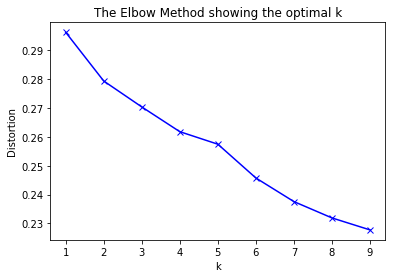

In [41]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(london_grouped_clustering)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(sum(np.min(cdist(london_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / london_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [44]:
#neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace = True)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = data

london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Location'), on='Location')

london_merged.head()

Location London_borough Postcode district  AvgPrice   Latitude  \
0  Abbey Wood         Bexley               SE2  368814.0  51.492450   
1   Crossness         Bexley               SE2  368814.0  51.492450   
2  West Heath         Bexley               SE2  368814.0  51.492450   
3   Addington        Croydon               CR0  347577.0  51.384755   
4  Addiscombe        Croydon               CR0  347577.0  51.384755   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0   0.121270             1.0           Supermarket         Train Station   
1   0.121270             1.0           Supermarket         Train Station   
2   0.121270             1.0           Supermarket         Train Station   
3  -0.051498             3.0     Recreation Center         Grocery Store   
4  -0.051498             3.0     Recreation Center         Grocery Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Platform     Convenience Store         Historic Site   
1              Platform     Convenience Store         Historic Site   
2              Platform     Convenience Store         Historic Site   
3     Fish & Chips Shop           Art Gallery           Zoo Exhibit   
4     Fish & Chips Shop           Art Gallery           Zoo Exhibit   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Zoo Exhibit           Flea Market    Falafel Restaurant   
1           Zoo Exhibit           Flea Market    Falafel Restaurant   
2           Zoo Exhibit           Flea Market    Falafel Restaurant   
3           Flower Shop        Farmers Market  Fast Food Restaurant   
4           Flower Shop        Farmers Market  Fast Food Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0        Farmers Market   Fast Food Restaurant  
1        Farmers Market   Fast Food Restaurant  
2        Farmers Market   Fast Food Restaurant  
3           Film Studio            Fish Market  
4           Film Studio            Fish Market

In [45]:
london_merged.dropna(inplace=True)


In [46]:
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)
london_merged.dtypes

Location                   object
London_borough             object
Postcode district          object
AvgPrice                  float64
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [47]:
london_merged.drop_duplicates(subset='Postcode district',inplace=True)
london_merged.reset_index(inplace=True)
london_merged.drop(columns='index',inplace=True)

In [48]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'],london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Text(0.5, 1.0, 'Price bins')

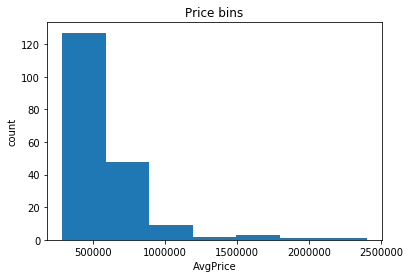

In [49]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(london_merged["AvgPrice"],bins=7)

# set x/y labels and plot title
plt.pyplot.xlabel("AvgPrice")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

In [50]:
bins = np.linspace(min(london_merged["AvgPrice"]), max(london_merged["AvgPrice"]), 8)
bins

array([ 285973.,  588157.,  890341., 1192525., 1494709., 1796893.,
       2099077., 2401261.])

In [51]:
group_names = ['Low level 1', 'Low level 2', 'Average level 1', 'Average level 2','Above Average','High level 1','High level 2']

In [52]:
london_merged['Price-Categories'] = pd.cut(london_merged['AvgPrice'], bins, labels=group_names, include_lowest=True )
london_merged[['AvgPrice','Price-Categories']].head()

AvgPrice Price-Categories
0   368814.0      Low level 1
1   347577.0      Low level 1
2   415224.0      Low level 1
3  1662350.0    Above Average
4   460101.0      Low level 1

Text(0.5, 1.0, 'Cluster Labels')

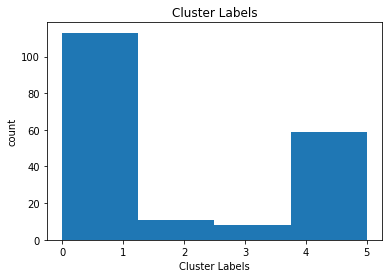

In [53]:
plt.pyplot.hist(london_merged["Cluster Labels"],bins=4)

# set x/y labels and plot title
plt.pyplot.xlabel("Cluster Labels")
plt.pyplot.ylabel("count")
plt.pyplot.title("Cluster Labels")

In [54]:
bins = np.linspace(min(london_merged["Cluster Labels"]), max(london_merged["Cluster Labels"]), 7)
bins

array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
       4.16666667, 5.        ])

In [55]:
group_names = ['Mixed Social Venues','Hotels and Social Venues','Stores and seafood restaurants','Pubs and Historic places', 'Sports and Athletics','Restaurants and Bars']

In [56]:
london_merged['Cluster-Category'] = pd.cut(london_merged['Cluster Labels'], bins, labels=group_names, include_lowest=True )
london_merged[['Cluster Labels','Cluster-Category']].head()

Cluster Labels          Cluster-Category
0               1  Hotels and Social Venues
1               3  Pubs and Historic places
2               4      Sports and Athletics
3               4      Sports and Athletics
4               4      Sports and Athletics

In [57]:
london_merged.drop(columns=['6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'],inplace=True)
london_merged.head(20)

Location        London_borough  \
0                                   Abbey Wood                Bexley   
1                                    Addington               Croydon   
2                             Aldborough Hatch             Redbridge   
3                                      Aldwych           Westminster   
4                                     Alperton                 Brent   
5                                      Anerley               Bromley   
6                                    Aperfield               Bromley   
7                                      Archway             Islington   
8                               Ardleigh Green              Havering   
9                                       Balham            Wandsworth   
10                                    Bankside             Southwark   
11                                    Barbican                  City   
12                                     Barking  Barking and Dagenham   
13                                 Barkingside             Redbridge   
14                                  Barnehurst                Bexley   
15                                      Barnes  Richmond upon Thames   
16                                 Barnes Cray                Bexley   
17  Barnet (also Chipping Barnet, High Barnet)                Barnet   
18                                   Barnsbury             Islington   
19                                   Battersea            Wandsworth   

   Postcode district   AvgPrice   Latitude  Longitude  Cluster Labels  \
0                SE2   368814.0  51.492450   0.121270               1   
1                CR0   347577.0  51.384755  -0.051498               3   
2                IG2   415224.0  51.506420  -0.127210               4   
3                WC2  1662350.0  51.516510  -0.119680               4   
4                HA0   460101.0  51.506420  -0.127210               4   
5               SE20   348970.0  51.410090  -0.056830               1   
6               TN16   445752.0  51.271793   0.074724               1   
7                N19   598216.0  51.563930  -0.129450               1   
8               RM11   513077.0  51.583700   0.174760               1   
9               SW12   627530.0  51.448220  -0.148390               1   
10               SE1   906486.0  51.499960  -0.095680               1   
11               EC1   891819.0  51.523610  -0.098770               1   
12              IG11   285973.0  51.533120   0.084077               3   
13               IG6   462086.0  51.506420  -0.127210               4   
14               DA7   422900.0  51.470520   0.146705               2   
15              SW13  1098276.0  51.474570  -0.242120               2   
16               DA1   291203.0  51.452068   0.172207               2   
17               EN5   621064.0  51.644415  -0.179183               2   
18                N1   755172.0  51.529690  -0.086970               1   
19              SW11   828769.0  51.467600  -0.162900               1   

     1st Most Common Venue 2nd Most Common Venue   3rd Most Common Venue  \
0              Supermarket         Train Station                Platform   
1        Recreation Center         Grocery Store       Fish & Chips Shop   
2                    Hotel               Theater                   Plaza   
3                      Pub        Sandwich Place                    Café   
4                    Hotel               Theater                   Plaza   
5              Supermarket         Grocery Store    Fast Food Restaurant   
6     Gym / Fitness Center         Historic Site            Soccer Field   
7            Grocery Store           Coffee Shop             Pizza Place   
8   Furniture / Home Store     Electronics Store                    Café   
9            Grocery Store           Coffee Shop                     Pub   
10                     Pub           Coffee Shop  Argentinian Restaurant   
11              Food Truck                   Pub             Coffee Shop   
12 

In [58]:
!wget -q -O 'london_boroughs_proper.json' https://skgrange.github.io/www/data/london_boroughs.json
print("data downloaded")

data downloaded


In [59]:
# Load the json file
with open('london_boroughs_proper.json') as lnd_geo_json:
    lnd_geo_data = json.load(lnd_geo_json)

In [60]:
lnd_geo = r'london_boroughs_proper.json'
lnd_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

lnd_map.choropleth(
    geo_data=lnd_geo,
    data=london_merged,
    columns=['London_borough','AvgPrice'],
    key_on='feature.properties.name',
    fill_color='RdPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average house Prices'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'],london_merged['Longitude'], london_merged['Location'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(lnd_map)
       
# display map
lnd_map

In [64]:
london_merged[london_merged['Cluster Labels']==0]


Location London_borough Postcode district  AvgPrice   Latitude  Longitude  \
31  Bickley        Bromley               BR3  455860.0  51.415095  -0.035403   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
31               0    Athletics & Sports                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
31         Train Station           Flea Market    Falafel Restaurant   

   Price-Categories     Cluster-Category  
31      Low level 1  Mixed Social Venues

In [62]:
london_merged[london_merged['Cluster Labels']==1]


Location  \
0                                        Abbey Wood   
5                                           Anerley   
6                                         Aperfield   
7                                           Archway   
8                                    Ardleigh Green   
9                                            Balham   
10                                         Bankside   
11                                         Barbican   
18                                        Barnsbury   
19                                        Battersea   
23                                     Bedford Park   
24                                        Belgravia   
25                                       Bellingham   
27                                     Belsize Park   
28                                        Belvedere   
30                                    Bethnal Green   
33                                      Blackfriars   
35                                        Blackwall   
36                                       Bloomsbury   
39                                       Bowes Park   
43                                         Brockley   
44                                         Plaistow   
45                                         Brompton   
46                                      Brondesbury   
48                                        Burnt Oak   
49                                   Burroughs, The   
50                                       Camberwell   
51                                      Camden Town   
52                                        Cann Hall   
53                                     Canning Town   
60                                      Childs Hill   
61                                        Chinatown   
62                                        Chinbrook   
63                                        Chingford   
65                                       Church End   
66                                          Clapham   
68                                        Colindale   
69                                    Colliers Wood   
71                                           Coombe   
75                                       Crouch End   
76                                           Cudham   
77                                          Dalston   
78                                         Deptford   
80                                       Earlsfield   
81                                     East Bedfont   
83                                    East Finchley   
84                                         East Ham   
85                                       East Sheen   
86                                     East Wickham   
87                                   Eel Pie Island   
89                                           Eltham   
90                                    Finsbury Park   
94                                     Fortis Green   
95                                           Fulham   
97                                    Golders Green   
99                                      Grange Park   
101                                       Greenwich   
102                                 Hackney Marshes   
104                                        The Hale   
106                                     Hammersmith   
109                                         Hanwell   
110                                        Hanworth   
112                                      Harlington   
115                                          Harrow   
119                                      Herne Hill   
120                                        Highbury   
122                                    Hither Green   
123                                        Holloway   
124                                        Hounslow   
127                                       Isleworth   
131                                    Kentish Town   
133                                   Kingston Vale   
135                         

In [63]:
london_merged[london_merged['Cluster Labels']==2]


Location        London_borough  \
14                                   Barnehurst                Bexley   
15                                       Barnes  Richmond upon Thames   
16                                  Barnes Cray                Bexley   
17   Barnet (also Chipping Barnet, High Barnet)                Barnet   
55                               Chadwell Heath             Redbridge   
56                                     Charlton             Greenwich   
57                                  Chase Cross              Havering   
92                                  Forest Gate                Newham   
93                                  Forest Hill              Lewisham   
117                                   Hatch End                Harrow   
118                                       Hayes               Bromley   

    Postcode district   AvgPrice   Latitude  Longitude  Cluster Labels  \
14                DA7   422900.0  51.470520   0.146705               2   
15               SW13  1098276.0  51.474570  -0.242120               2   
16                DA1   291203.0  51.452068   0.172207               2   
17                EN5   621064.0  51.644415  -0.179183               2   
55                RM6   350694.0  51.572892   0.147529               2   
56                SE7   427639.0  51.487590   0.029120               2   
57                RM5   389677.0  51.506420  -0.127210               2   
92                 E7   454709.0  51.546680   0.025580               2   
93               SE23   459281.0  51.441220  -0.047640               2   
117               HA5   604720.0  51.612907  -0.376964               2   
118               BR2   510478.0  51.506420  -0.127210               2   

          1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
14                          Pub     Convenience Store     Indian Restaurant   
15                          Pub           Pizza Place        Farmers Market   
16                          Pub         Track Stadium    Italian Restaurant   
17                          Pub           Coffee Shop     Recruiting Agency   
55                   Hookah Bar                   Pub              Pharmacy   
56                  Supermarket        Clothing Store           Coffee Shop   
57                        Hotel               Theater                 Plaza   
92                Grocery Store                   Pub  Fast Food Restaurant   
93                          Pub                  Café         Train Station   
117  Construction & Landscaping                 Trail    Athletics & Sports   
118                       Hotel               Theater                 Plaza   

    4th Most Common Venue 5th Most Common Venue Price-Categories  \
14                 Forest           Flower Shop      Low level 1   
15                   Park         Grocery Store  Average level 1   
16   Medical Supply Store           Supermarket      Low level 1   
17                   Café           Flower Shop      Low level 2   
55            Flower Shop    Falafel Restaurant      Low level 1   
56    Sporting Goods Shop        Soccer Stadium      Low level 1   
57                 Garden                   Pub      Low level 1   
92               Bus Stop                  Café      Low level 1   
93      Fish & Chips Shop            Beer Store      Low level 1   
117                  Park           Flower Shop      Low level 2   
118                Garden                   Pub      Low level 1   

                   Cluster-Category  
14   Stores and seafood restaurants  
15   Stores and seafood restaurants  
16   Stores and seafood restaurants  
17   Stores and seafood restaurants  
55   Stores and seafood restaurants  
56   Stores and seafood restaurants  
57   Stores and seafood restaurants  
92   Stores and seafood restaurants  
93   Stores and seafood restaurants  
117  Stores and seafood restaurants  
118  Stores and seafood restaurants

In [65]:
london_merged[london_merged['Cluster Labels']==3]


Location        London_borough Postcode district  AvgPrice  \
1         Addington               Croydon               CR0  347577.0   
12          Barking  Barking and Dagenham              IG11  285973.0   
32         Blackfen                Bexley              DA15  392869.0   
41       Brent Park                 Brent              NW10  525095.0   
47   Brunswick Park                Barnet               N11  513066.0   
108    Hampton Wick  Richmond upon Thames               KT1  518428.0   
126          Ilford             Redbridge               IG1  374741.0   
167      Rush Green  Barking and Dagenham               RM7  352938.0   

      Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
1    51.384755  -0.051498               3     Recreation Center   
12   51.533120   0.084077               3         Grocery Store   
32   51.452281   0.099796               3         Grocery Store   
41   51.539160  -0.251230               3         Grocery Store   
47   51.616310  -0.138390               3         Grocery Store   
108  51.351434  -0.249880               3         Grocery Store   
126  51.551160   0.078960               3                  Park   
167  51.574095   0.168002               3             Racetrack   

    2nd Most Common Venue       3rd Most Common Venue 4th Most Common Venue  \
1           Grocery Store           Fish & Chips Shop           Art Gallery   
12                   Park                         Spa                  Café   
32               Bus Stop                   Gastropub     Convenience Store   
41     Chinese Restaurant              Sandwich Place       Warehouse Store   
47          Metro Station                    Beer Bar         Train Station   
108                   Pub                 Coffee Shop                  Café   
126         Event Service               Grocery Store        Ice Cream Shop   
167         Grocery Store  Construction & Landscaping       Motorcycle Shop   

    5th Most Common Venue Price-Categories          Cluster-Category  
1             Zoo Exhibit      Low level 1  Pubs and Historic places  
12            Supermarket      Low level 1  Pubs and Historic places  
32                   Food      Low level 1  Pubs and Historic places  
41               Pharmacy      Low level 1  Pubs and Historic places  
47      Fish & Chips Shop      Low level 1  Pubs and Historic places  
108                  Park      Low level 1  Pubs and Historic places  
126           Flea Market      Low level 1  Pubs and Historic places  
167              Fountain      Low level 1  Pubs and Historic places

In [66]:
london_merged[london_merged['Cluster Labels']==4]


Location          London_borough Postcode district   AvgPrice  \
2    Aldborough Hatch               Redbridge               IG2   415224.0   
3             Aldwych             Westminster               WC2  1662350.0   
4            Alperton                   Brent               HA0   460101.0   
13        Barkingside               Redbridge               IG6   462086.0   
20          Bayswater             Westminster                W2  1057096.0   
21          Becontree    Barking and Dagenham               RM9   317805.0   
22    Becontree Heath    Barking and Dagenham               RM8   320000.0   
26            Belmont                  Sutton               SM2   350331.0   
29         Berrylands    Kingston upon Thames               KT5   492102.0   
54         Carshalton                  Sutton               SM5   429161.0   
58         Chelsfield                 Bromley               BR6   544548.0   
59        Chessington    Kingston upon Thames               KT9   397827.0   
67        Cockfosters                  Barnet               EN4   754047.0   
70            Colyers                  Bexley               DA8   304840.0   
72           Coulsdon                 Croydon               CR5   491406.0   
73             Cowley              Hillingdon               UB8   400021.0   
74           Cranford                Hounslow               TW5   478645.0   
79        Derry Downs                 Bromley               BR5   450548.0   
88           Elm Park                Havering              RM12   423500.0   
98          Goodmayes               Redbridge               IG3   477533.0   
100         Greenford                  Ealing               UB6   436316.0   
103          Hainault               Redbridge               IG7   553883.0   
105               Ham    Richmond upon Thames              TW10   766188.0   
107           Hampton    Richmond upon Thames              TW12   527857.0   
111         Harefield              Hillingdon               UB9   519324.0   
113     Harmondsworth              Hillingdon               UB7   376081.0   
114       Harold Hill                Havering               RM3   355108.0   
116      Harrow Weald                  Harrow               HA3   459331.0   
125          Ickenham              Hillingdon              UB10   518935.0   
128            Kenley                 Croydon               CR8   442031.0   
130        Kensington  Kensington and Chelsea               SW7  2081929.0   
132               Kew    Richmond upon Thames               TW9   716510.0   
134           Lampton                Hounslow               TW4   356220.0   
149          Northolt                  Ealing               UB5   321538.0   
150         Northwood              Hillingdon               HA6   585170.0   
151     Norwood Green                  Ealing               UB2   392152.0   
155        Old Malden    Kingston upon Thames               KT4   504928.0   
163         Redbridge               Redbridge               IG4   604062.0   
166           Ruislip              Hillingdon               HA4   506996.0   
168       Sanderstead                 Croydon               CR2   377732.0   
172      South Harrow                  Harrow               HA2   468915.0   
188           Whitton    Richmond upon Thames               TW2   548367.0   
189    Woodford Green               Redbridge               IG8   559158.0   
190           Yeading              Hillingdon               UB4   375355.0   

     Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
2    51.50642  -0.127210               4                 Hotel   
3    51.51651  -0.119680               4                   Pub   
4    51.50642  -0.127210               4                 Hotel   
13   51.50642  -0.127210               4                 Hotel   
20   51.51494  -0.180480               4                 Hotel   
21   51.50642  -0.127210               4                 Hotel   
22   51.50642  -0.127210               4

In [ ]:
london_merged[london_merged['Cluster Labels']==5]


Location London_borough Postcode district  AvgPrice   Latitude  \
34       Blackheath       Lewisham               SE3  516134.0  51.471380   
37       Botany Bay        Enfield               EN2  516077.0  51.653660   
38              Bow  Tower Hamlets                E3  448271.0  51.527020   
40        Brentford       Hounslow               TW8  498277.0  51.487701   
42        Brimsdown        Enfield               EN3  350927.0  51.643220   
64      Chislehurst        Bromley               BR7  594775.0  51.413275   
82     East Dulwich      Southwark              SE22  591350.0  51.452560   
91       Foots Cray         Bexley              DA14  353322.0  51.452068   
96       Gidea Park       Havering               RM2  490936.0  51.475874   
121        Highgate         Camden                N6  867061.0  51.571450   
129      Kennington        Lambeth              SE11  600318.0  51.490840   
137   Little Ilford         Newham               E12  378523.0  51.552410   
139    Lower Morden         Merton               SM4  413610.0  51.392200   
147         Norbury        Croydon              SW16  476239.0  51.418700   
178  Thornton Heath        Croydon               CR7  336105.0  51.396315   

     Longitude  Cluster Labels       1st Most Common Venue  \
34    0.023380               5                         Pub   
37   -0.110614               5  Construction & Landscaping   
38   -0.025940               5                         Pub   
40   -0.297795               5                         Pub   
42   -0.043790               5                         Pub   
64    0.087474               5                         Pub   
82   -0.070760               5                         Bar   
91    0.172207               5                         Pub   
96    0.276114               5           Indian Restaurant   
121  -0.149830               5                         Pub   
129  -0.111080               5                         Pub   
137   0.052580               5                         Pub   
139  -0.215950               5                         Pub   
147  -0.127530               5                         Pub   
178  -0.106608               5                         Pub   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
34     Photography Studio           Zoo Exhibit           Flea Market   
37                    Pub                  Lake                  Food   
38              Locksmith              Bus Stop         Grocery Store   
40                  Hotel        History Museum            Restaurant   
42                   Café            Playground           Supermarket   
64        Nature Preserve              Gym Pool           Zoo Exhibit   
82                    Pub             Gastropub         Grocery Store   
91          Track Stadium    Italian Restaurant  Medical Supply Store   
96                    Pub    Chinese Restaurant  Fast Food Restaurant   
121                Bakery           Coffee Shop                  Pool   
129           Pizza Place             Gastropub                  Café   
137            Restaurant           Gas Station  Gym / Fitness Center   
139         Garden Center                  Café           Zoo Exhibit   
147          Burger Joint           Pizza Place           Supermarket   
178     Indian Restaurant         Grocery Store     Martial Arts Dojo   

    5th Most Common Venue Price-Categories      Cluster-Category  
34     Falafel Restaurant      Low level 1  Restaurants and Bars  
37         Farmers Market      Low level 1  Restaurants and Bars  
38           Burger Joint      Low level 1  Restaurants and Bars  
40           Cocktail Bar      Low level 1  Restaurants and Bars  
42     Turkish Restaurant      Low level 1  Restaurants and Bars  
64            Flea Market      Low level 2  Restaurants and Bars  
82                   Park      Low level 2  Restaurants and Bars  
91            Supermarket      Low level 1  Restaurants and Bars  
96           

In [ ]:
london_merged[london_merged['Price-Categories']=='High level 2']


In [ ]:
london_merged[london_merged['Price-Categories']=='High level 1']


In [ ]:
london_merged[london_merged['Price-Categories']=='Low level 2']


In [ ]:
london_merged[london_merged['Price-Categories']=='Low level 1']
